### TEAM ZM5

# EDSA MOVIE RECOMMENDATION CHALLENGE 

### Installing packages
Please download all relevant packages in. There is no terminal so you will need to pip install everything.

In [ ]:
#!wget 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/27685/2229266/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1626387714&Signature=KygcspWYq74MDW0sfdmsG%2BKzbIVu7bAXbXSgGzeRSkW1y50gc6YBYMtbWZMOlxFxGTB4M8pHrDatrNrM7K1O7uBHHp6x1h3QEEHSnSa1X4tTYBy%2BiExhUNlV5Ez1E9Df5zYELJM1iOOtpnqWBcsndQN3mGXbpPgN4a9DBmihapuzgRXhixTX8Y3qyY9KJkoi99azSOVvQEj4S57R2KpqKOozaJUNNLSuV9z6KOoE0qzUq3%2FA5vvKE7uN7sG%2B5mmkmqAShUwzuurKBMGlty0%2FCCs8Yalhbfbto2PI4Yr%2BZJgpjxueDILjj1n1zcfeAQ083InWmYWZdd3Jbgyp4fIy0w%3D%3D&response-content-disposition=attachment%3B+filename%3Dedsa-movie-recommendation-challenge.zip'

In [ ]:
#!unzip 'archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1626387714&Signature=KygcspWYq74MDW0sfdmsG+KzbIVu7bAXbXSgGzeRSkW1y50gc6YBYMtbWZMOlxFxGTB4M8pHrDatrNrM7K1O7uBHHp6x1h3QEEHSnSa1X4tTYBy+iExhUNlV5Ez1E9Df5zYEL'

In [ ]:
#!pip install LibRecommender
#!pip install surprise
#!pip install comet_ml
#!pip install seaborn

### Imports

In [1]:
import comet_ml

In [2]:
# First import comet_ml at the top of your file
from comet_ml import Experiment

In [3]:
# Create an experiment with your api key for version control
experiment = Experiment(
    api_key="amGQj1TC3Wyk9LYf7bD9xNV6G",
    project_name="movie-reccomender-edsa",
    workspace="daniel-bru",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/daniel-bru/movie-reccomender-edsa/9abeba71f2c648d6b786ccb76f4b0f0e



In [35]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

from libreco.data import random_split, DatasetPure, DataInfo
from libreco.data import split_by_ratio_chrono, DatasetFeat
from libreco.algorithms import SVD as libSVD
from libreco.algorithms import SVDpp, BPR
from libreco.algorithms import FM, WideDeep, DeepFM, AutoInt, DIN
from libreco.evaluation import evaluate
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_WARNINGS"] = "FALSE"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time
from time import sleep
import gc

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

### Reading in data

In [36]:
root_path = ''
# df_sample_submission = pd.read_csv(root_path + 'sample_submission.csv')
df_movies = pd.read_csv(root_path + 'movies.csv')
# df_imdb = pd.read_csv(root_path + 'imdb_data.csv')
# df_genome_scores = pd.read_csv(root_path + 'genome_scores.csv')
# df_genome_tags = pd.read_csv(root_path +'genome_tags.csv')
train = pd.read_csv(root_path + 'train.csv')
# df_test = pd.read_csv(root_path + 'test.csv')
# df_tags = pd.read_csv(root_path + 'tags.csv')
# df_links = pd.read_csv(root_path + 'links.csv')

In [6]:
pd.set_option("display.max.column", None)
print(df_sample_submission.info())
df_sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
Id        object
rating    float64
dtypes: float64(1), object(1)
memory usage: 76.3+ MB
None


,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [7]:
print(df_movies.info())
df_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
movieId    62423 non-null int64
title      62423 non-null object
genres     62423 non-null object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
print(df_imdb.info())
df_imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
movieId          27278 non-null int64
title_cast       17210 non-null object
director         17404 non-null object
runtime          15189 non-null float64
budget           7906 non-null object
plot_keywords    16200 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB
None


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [9]:
print(df_genome_scores.info())
df_genome_scores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
movieId      int64
tagId        int64
relevance    float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB
None


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [10]:
print(df_genome_tags.info())
df_genome_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
tagId    1128 non-null int64
tag      1128 non-null object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
None


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [11]:
print(df_tags.info())
df_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
userId       1093360 non-null int64
movieId      1093360 non-null int64
tag          1093344 non-null object
timestamp    1093360 non-null int64
dtypes: int64(3), object(1)
memory usage: 33.4+ MB
None


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [12]:
print(df_links.info())
df_links.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
movieId    62423 non-null int64
imdbId     62423 non-null int64
tmdbId     62316 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB
None


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [14]:
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
userId     int64
movieId    int64
dtypes: int64(2)
memory usage: 76.3 MB
None


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


# Exploratory Data Analysis

**Most common Genres**

In [15]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


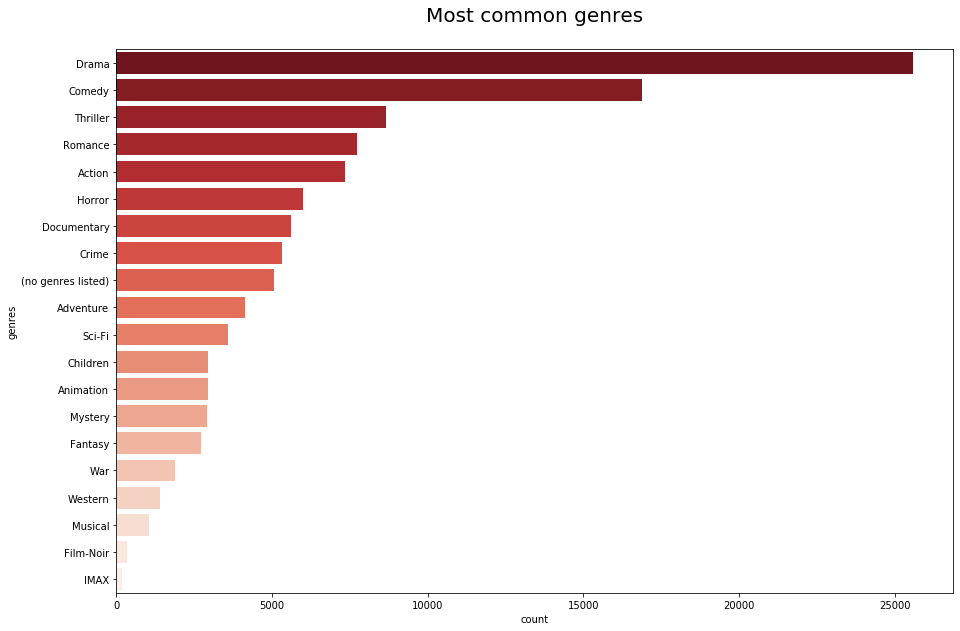

In [16]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

**Most common actors**

In [17]:
# Create dataframe containing only the movieId and cast members
cast = pd.DataFrame(df_imdb[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_cast seperated by "|" and create a list containing the cast members in each movie
cast.title_cast = cast.title_cast.astype(str).apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie - cast member combination is in a seperate row
cast = pd.DataFrame([(tup.movieId, d) for tup in cast.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])

mostc_cast = cast['title_cast'].value_counts(ascending=False).index.tolist()[:50]

print('Total Cast Members:', len(list(cast['title_cast'].unique())))
print('Most Common Cast Members:\n', mostc_cast)
display(cast.head())

Total Cast Members: 121036
Most Common Cast Members:
 ['nan', 'Samuel L. Jackson', 'Steve Buscemi', 'Keith David', 'Willem Dafoe', 'Robert De Niro', 'Gérard Depardieu', 'Brian Cox', 'Christopher Walken', 'Danny Glover', 'Morgan Freeman', 'Bruce Willis', 'Peter Stormare', 'Nicolas Cage', 'Alec Baldwin', 'Julianne Moore', 'Richard Jenkins', 'Stanley Tucci', 'Susan Sarandon', 'John Goodman', 'Woody Harrelson', 'Tom Wilkinson', 'Stellan Skarsgård', 'Christopher McDonald', 'Antonio Banderas', 'Val Kilmer', 'Jeff Bennett', 'Johnny Depp', 'Ed Harris', 'Harvey Keitel', 'John Leguizamo', 'Ray Liotta', 'Forest Whitaker', 'Donald Sutherland', 'John Cusack', 'Luis Guzmán', 'Stephen Tobolowsky', 'Paul Giamatti', 'Ewan McGregor', 'Richard Riehle', 'George W. Bush', 'David Strathairn', 'Danny Trejo', 'Jim Broadbent', 'John Malkovich', 'Ving Rhames', 'Kathy Bates', 'Patricia Clarkson', 'Robert Downey Jr.', 'Jim Cummings']


,movieId,title_cast
0,1,Tom Hanks
1,1,Tim Allen
2,1,Don Rickles
3,1,Jim Varney
4,1,Wallace Shawn


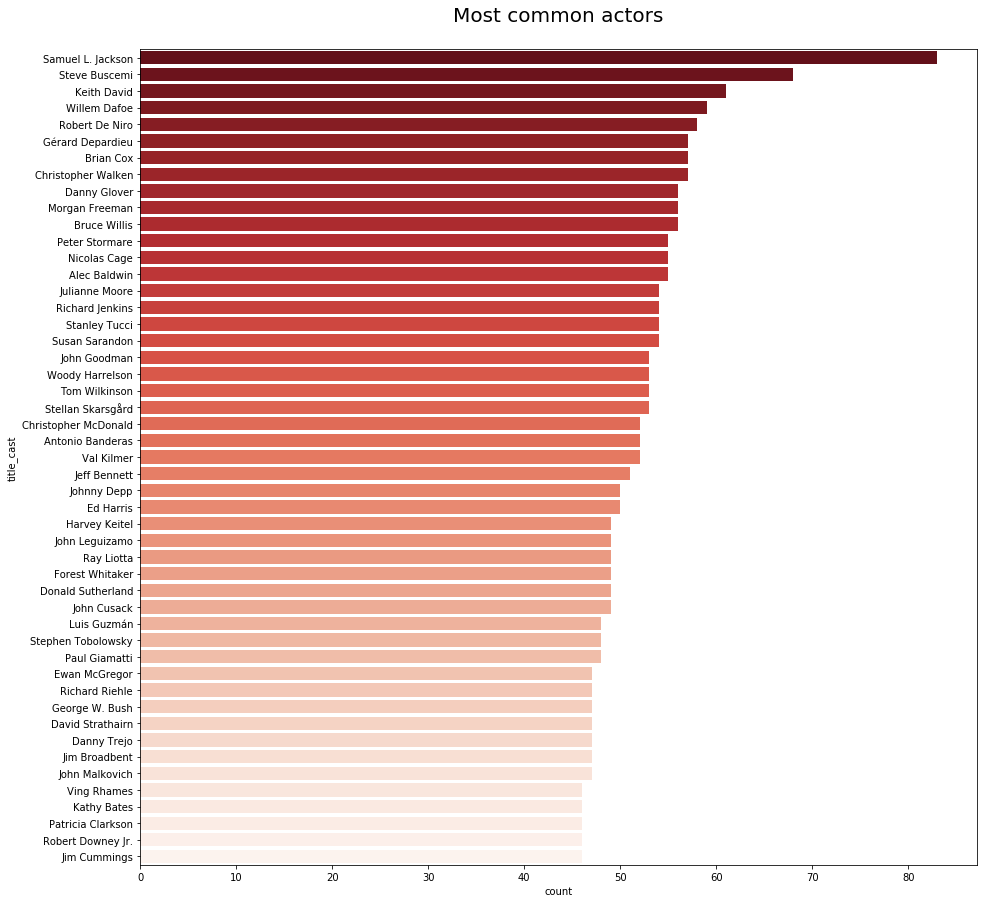

In [18]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 15))
plt.title('Most common actors\n', fontsize=20)
sns.countplot(y="title_cast", data=cast,
              order=mostc_cast[1:50],
              palette='Reds_r')
plt.show()

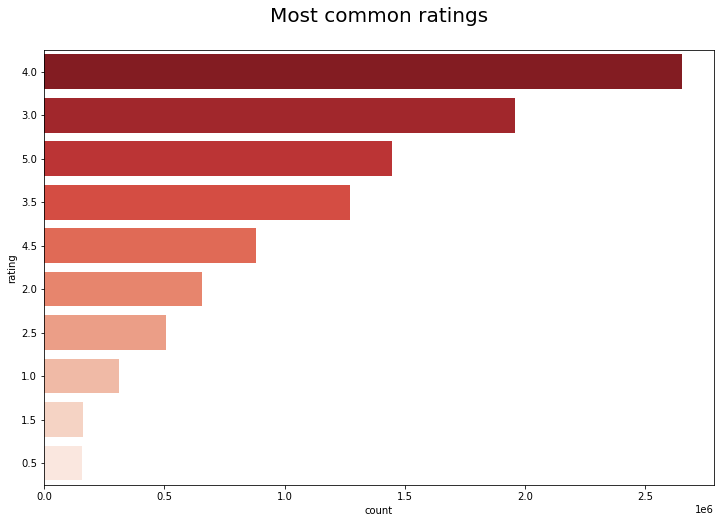

In [10]:
# Plot the genres from most common to least common
ratings = train['rating'].value_counts(ascending=False).index.tolist()[:50]

plot = plt.figure(figsize=(12, 8))
plt.title('Most common ratings\n', fontsize=20)
sns.countplot(y="rating", data=train,
              order=ratings,
              palette='Reds_r')
plt.show()

Here we can see the distribution of the ratings. There seems to be quite a few movies with a prefect rating.
Movies with a perfect rating could be a result of it only being rated by a very small amount of people or even just once.

In [38]:
temp_df = pd.merge(train,df_movies,on='movieId')

In [56]:
# mean of ratings a movie has received 
temp_df.groupby('title')['rating'].mean().head()

title
"BLOW THE NIGHT!" Let's Spend the Night Together (1983)    3.000000
"Great Performances" Cats (1998)                           2.753731
#1 Cheerleader Camp (2010)                                 1.900000
#Female Pleasure (2018)                                    4.000000
#FollowMe (2019)                                           2.400000
Name: rating, dtype: float64

In [55]:
temp_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Which Way Home (2009)               5.0
Kaakha Kaakha (2003)                5.0
Not Quite Human II (1989)           5.0
Selling Isobel (2018)               5.0
Sehar (2005)                        5.0
The Enchanted Sedan Chair (1905)    5.0
K.G.F: Chapter 1 (2018)             5.0
Hard Cash (2002)                    5.0
Everyone's Going to Die (2013)      5.0
Anything for Love (2016)            5.0
Name: rating, dtype: float64

In [58]:
# Movies which have been rated the most
temp_df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Shawshank Redemption, The (1994)             32831
Forrest Gump (1994)                          32383
Pulp Fiction (1994)                          31697
Silence of the Lambs, The (1991)             29444
Matrix, The (1999)                           29014
Star Wars: Episode IV - A New Hope (1977)    27560
Jurassic Park (1993)                         25518
Schindler's List (1993)                      24004
Braveheart (1995)                            23722
Fight Club (1999)                            23536
Name: rating, dtype: int64

Finally some movies I have seen.

In [61]:
# creating df for ploting the mean for each movies ratings
rating_mean_count = pd.DataFrame(temp_df.groupby('title')['rating'].mean())
rating_mean_count['rating_count'] = pd.DataFrame(temp_df.groupby('title')['rating'].count())

Text(0.5, 1.0, 'Movies mean rating')

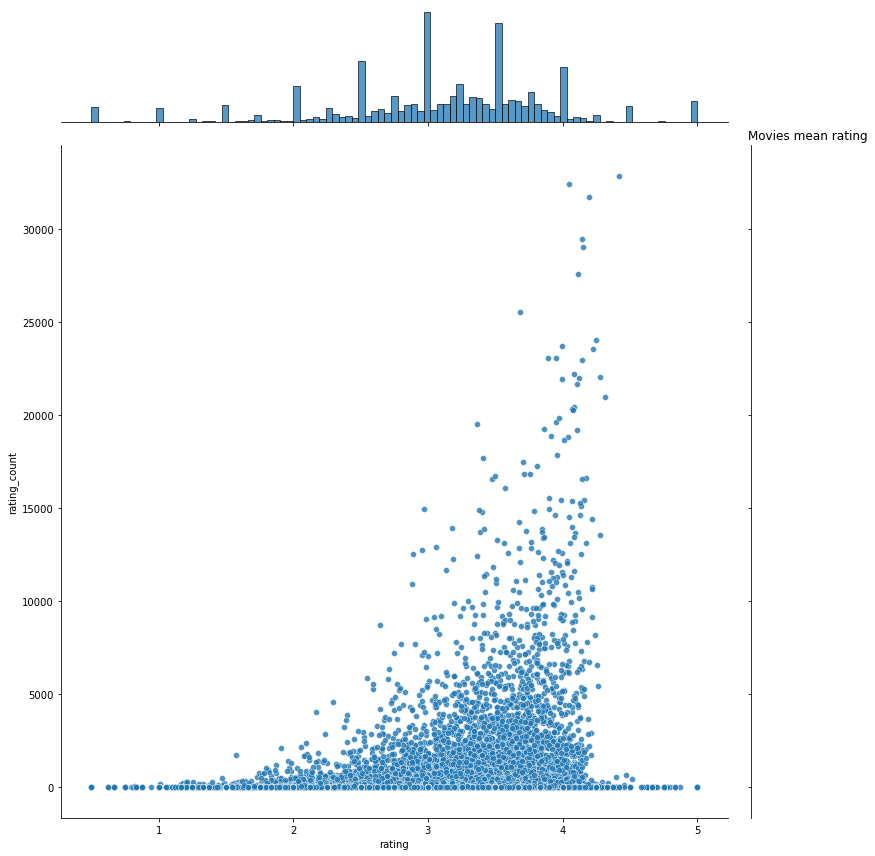

In [78]:
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_count', data=rating_mean_count, alpha=0.8, height=12)
plt.title("Movies mean rating")

In [79]:
# Count number of ratings movie has received
temp_df.groupby('title')['rating'].count().sort_values(ascending=True).head(10)

title
"BLOW THE NIGHT!" Let's Spend the Night Together (1983)    1
Love's Coming (2014)                                       1
Love's Brother (2004)                                      1
Love's Abiding Joy (2006)                                  1
Love on the Dole (1941)                                    1
Love on a Pillow (1962)                                    1
Love on Sunday (2006)                                      1
Love on Ice (2017)                                         1
Love of My Life (2013)                                     1
Love me! (2014)                                            1
Name: rating, dtype: int64

In [82]:
rating_mean_count[rating_mean_count['rating_count']==1].count()

rating          12509
rating_count    12509
dtype: int64

There is quite a few movies in this dataset which have only received one rating are then people niche tastes or are they hidden gems that the masses do not know about.

In [71]:
# count of ratings a user left

temp_df.groupby('userId')['rating'].count().sort_values(ascending=True).head(10)

userId
105714    1
53640     1
127098    1
121071    1
55362     1
79087     1
120862    2
153150    2
113147    2
138028    2
Name: rating, dtype: int64

We can see that some users have only rated a very small amount of movies. We wont be able to to compare these users like or dislikes because there is too little information on them.

In [33]:
# freeing up memory
gc.collect()
del temp_df
del rating_mean_count

# Recomendation Models

* Collaborative Filtering 

### Data Preprocessing

In [ ]:
df_train = train.copy()

"""Counting the number of times a movie has recieved an rating"""
rating_count = df_train.groupby('movieId')['rating'].count().reset_index()
rating_count.rename(columns = {'rating': 'movie_rating_count'}, inplace=True)
df_train = df_train.merge(rating_count, on='movieId')

"""Counting the number of times a user has left an rating"""
user_count = df_train.groupby('userId')['rating'].count().reset_index()
user_count.rename(columns={'rating': 'user_rating_count'}, inplace=True)
df_train=df_train.merge(user_count, on='userId')

"""Droping all movies/users which are below a threshhold"""
mrc = 20
urc = 5
df_train = df_train[df_train['movie_rating_count'] > mrc]
df_train = df_train[df_train['user_rating_count'] > urc]
display(df_train.head(3))
print(df_train.shape)
df_train.drop(['movie_rating_count','user_rating_count'], 1, inplace=True)

display(df_train.head(3))
print(df_train.shape)

In [154]:
def create_features(df, column, features):
    """Creates features from a column of lists where the list items will be the features."""
    
    features_df = pd.DataFrame(columns = features)
    all_features = pd.concat([df, features_df], axis=1)

    for i,row in all_features.iterrows():
        for feature in features:
            if feature in getattr(row,column):
                all_features[feature].iloc[i]= 1
    all_features = all_features.drop(column, axis=1)
    
    return all_features

In [155]:
"""Fill NaN's and extract numbers from budget"""
df_imdb.fillna(0, inplace=True)
df_imdb.budget = df_imdb.budget.astype(str).apply(lambda x: int(re.sub("[^0-9]", "", x)))

In [156]:
%%time
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))
genres = ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)']

genre_encode = create_features(movies_genres, 'genres', genres)
genre_encode.head(4)

CPU times: user 3min 26s, sys: 64.4 ms, total: 3min 26s
Wall time: 3min 26s


,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,1,1,1,1,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,1,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,1,NaN,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
%%time
cast = pd.DataFrame(df_imdb[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_cast seperated by "|" and create a list containing the cast members in each movie
cast.title_cast = cast.title_cast.astype(str).apply(lambda x: x.split('|'))
cast_movie = pd.DataFrame([(tup.movieId, d) for tup in cast.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])
mostc_cast = cast_movie['title_cast'].value_counts(ascending=False).index.tolist()[:16]

cast_encode = create_features(cast, 'title_cast', mostc_cast[1:])
cast_encode.head(4)

CPU times: user 11.6 s, sys: 0 ns, total: 11.6 s
Wall time: 11.6 s


,movieId,Samuel L. Jackson,Steve Buscemi,Keith David,Willem Dafoe,Robert De Niro,Christopher Walken,Brian Cox,Gérard Depardieu,Danny Glover,Bruce Willis,Morgan Freeman,Alec Baldwin,Nicolas Cage,Peter Stormare,Stanley Tucci
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
gc.collect()
del rating_count, user_count, movies_genres, cast, cast_movie
sleep(2)

## Modelling 



### Collaborative Filtering 

In [142]:
%%time
ratings = df_train.copy()
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

CPU times: user 14.7 s, sys: 1.74 s, total: 16.4 s
Wall time: 16.4 s


In [143]:
%%time
trainset, testset = train_test_split(data, test_size=.01, random_state = 1)

CPU times: user 26.5 s, sys: 582 ms, total: 27.1 s
Wall time: 27.1 s


In [144]:
gc.collect()
del ratings, ratings_dict, df, data
sleep(10)

### Surprise
#### SVD
SVD is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K<N).

In [145]:
%%time
algo = SVD(verbose=True)
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE
accuracy.rmse(predictions)
accuracy.mae(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.7862
MAE:  0.6018
CPU times: user 8min 47s, sys: 123 ms, total: 8min 47s
Wall time: 8min 47s


0.6018093596139479

In [146]:
gc.collect()
del algo
sleep(10)

#### Hyperparameter tuned SVD

In [147]:
%%time
algo = SVD(random_state = 1, n_epochs= 16, verbose=True, n_factors =220, lr_all = 0.016, reg_all =0.02, 
           init_std_dev = 0.005, init_mean = -0.037)
# Train the algorithm on the trainset, and predict ratings for the testset 
algo.fit(trainset)
predictions = algo.test(testset) 

# Compute RMSE
accuracy.rmse(predictions) # RMSE: 0.8028 
accuracy.mae(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
RMSE: 0.7708
MAE:  0.5860
CPU times: user 12min 47s, sys: 0 ns, total: 12min 47s
Wall time: 12min 47s


0.5859704493473294

In [148]:
gc.collect()
del algo, trainset, testset, 
sleep(10)

In [ ]:
#trainset = data.build_full_trainset()
#algo = SVD(random_state = 1, n_epochs= 16, verbose=True, n_factors =220, lr_all = 0.016, reg_all =0.02, init_std_dev = 0.005, init_mean = -0.037)
#algo.fit(trainset)

### LibRecommender

In [175]:
%%time
data = df_train.copy()
data.rename(columns={'userId':'user', 'movieId':'item','rating':'label', 
                               'timestamp':'time'}, inplace=True)

# split whole data into three folds for training, evaluating and testing
train_data, eval_data, test_data = random_split(data, multi_ratios=[0.99, 0.005, 0.005])

# building data sets
train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 162541, n_items: 4869, data sparsity: 1.1327 %
CPU times: user 22.7 s, sys: 2.02 s, total: 24.7 s
Wall time: 24.7 s


In [127]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

#### SVD

In [ ]:
%%time
reset_state('libSVD')
svd_lib = libSVD(task="rating", data_info=data_info, embed_size=8, n_epochs=3, lr=0.0048, batch_size=10000, 
                 batch_sampling=True)  # embed_size=8, n_epochs=3, lr=0.005,batch_size=10000
# monitor metrics on eval_data during training
svd_lib.fit(train_data, verbose=2, eval_data=eval_data, metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=svd_lib, data=test_data,
                                    metrics=["rmse", "mae"]))

In [129]:
print("prediction: ", svd_lib.predict(user=5163, item=57669))
print("recommendation: ", svd_lib.recommend_user(user=5163, n_rec=5))
svd_lib.predict(df_train['userId'][:10], df_train['movieId'][:10])

prediction:  [4.40771]
recommendation:  [(2959, 4.9423904), (296, 4.88998), (288, 4.7672167), (116897, 4.746368), (159817, 4.7333198)]


array([4.40771  , 2.858386 , 4.208558 , 4.4185195, 3.532493 , 4.1347685,
       4.1783595, 3.8288686, 4.2823944, 4.167843 ], dtype=float32)

In [130]:
gc.collect()
del data, svd_lib
sleep(10)

#### SVDpp

In [132]:
%%time
reset_state('SVDpp')
svdpp = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, lr=0.0048,batch_size=10000,
              batch_sampling=True)  # embed_size=16, n_epochs=2, lr=0.005,batch_size=10000
# monitor metrics on eval_data during training
svdpp.fit(train_data, verbose=2, eval_data=eval_data, metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=svdpp, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== SVDpp ==============================
Training start time: 2021-07-13 07:42:54


train: 100%|██████████| 897/897 [11:40<00:00,  1.28it/s]


Epoch 1 elapsed: 705.193s
	 train_loss: 0.6592


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 526.27it/s]


	 eval rmse: 0.7710
	 eval mae: 0.5955
	 eval r2: 0.4011


train: 100%|██████████| 897/897 [11:32<00:00,  1.30it/s]


Epoch 2 elapsed: 697.318s
	 train_loss: 0.5441


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 545.00it/s]


	 eval rmse: 0.7607
	 eval mae: 0.5847
	 eval r2: 0.4170


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 538.17it/s]

evaluate_result:  {'rmse': 0.75702052264262, 'mae': 0.5811714384804062}
CPU times: user 30min 26s, sys: 8min 12s, total: 38min 39s
Wall time: 23min 31s


In [133]:
print("prediction: ", svdpp.predict(user=5163, item=57669))
print("recommendation: ", svdpp.recommend_user(user=5163, n_rec=5))
svdpp.predict(df_train['userId'][:10], df_train['movieId'][:10])

prediction:  [4.354411]
recommendation:  [(296, 5.1158895), (6874, 4.8834662), (86345, 4.8747015), (1136, 4.7870274), (7438, 4.7602425)]


array([4.354411 , 3.0401978, 4.0746274, 4.5748396, 3.4525025, 4.2924614,
       4.559071 , 3.7208931, 4.2276306, 4.517718 ], dtype=float32)

In [134]:
gc.collect()
del svdpp, train_data, data_info, eval_data, test_data
sleep(10)

Train SVDpp on full dataset

In [ ]:
# data = pd.read_csv(root_path + 'train.csv', header=0, names = ["user", "item", "label", "time"])
# train_data, data_info = DatasetPure.build_trainset(data)

# reset_state('SVDpp')
# svdpp = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, lr=0.005,batch_size=10000, batch_sampling=True)
# svdpp.fit(train_data, verbose=2)

Save SVDpp model

In [ ]:
"""
data_info.save(path="SVDpp_model_path")
svdpp.save(path="SVDpp_model_path", model_name="svdpp_model", manual=True,
                inference_only=False)
"""

In [ ]:
"""
tf.compat.v1.reset_default_graph()
data_info = DataInfo.load("SVDpp_model_path")

svdpp_loaded = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, 
                                                lr=0.005,batch_size=10000, batch_sampling=True)

data = pd.read_csv(root_path + 'train.csv', header=0, names = ["user", "item", "label", "time"])
train_data, eval_data, test_data = random_split(data, multi_ratios=[0.99, 0.005, 0.005])
train_data, data_info = DatasetPure.build_trainset(train_data)
svdpp_loaded.rebuild_graph(path="SVDpp_model_path", model_name="svdpp_model",
                        full_assign=True, train_data=train_data)
"""

In [ ]:
#svdpp_loaded.predict(df_train['userId'][:10], df_train['movieId'][:10])

### Hybrid Models

In [162]:
%%time

""" Creating more features from genre and cast"""

mergeded_train = df_train.copy()
mergeded_train = pd.merge(mergeded_train, genre_encode,on= 'movieId', how='left')
mergeded_train = pd.merge(mergeded_train, cast_encode, on= 'movieId', how='left')

CPU times: user 8.84 s, sys: 4.16 s, total: 13 s
Wall time: 13 s


In [163]:
gc.collect()
del genre_encode, cast_encode
sleep(10)

In [164]:
%%time
mergeded_train = pd.merge(mergeded_train, df_imdb[['movieId', 'runtime', 
                                                   'budget']], on= 'movieId').fillna(0)
display(mergeded_train.head())
print(mergeded_train.shape)

,userId,movieId,rating,timestamp,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Gérard Depardieu,Danny Glover,Bruce Willis,Morgan Freeman,Alec Baldwin,Nicolas Cage,Peter Stormare,Stanley Tucci,runtime,budget
0,5163,57669,4.0,1518349992,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000
1,87388,57669,3.5,1237455297,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000
2,137050,57669,4.0,1425631854,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000
3,120490,57669,4.5,1408228517,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000
4,50616,57669,4.5,1446941640,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000


(8836510, 41)
CPU times: user 1min 39s, sys: 18.7 s, total: 1min 57s
Wall time: 1min 57s


In [165]:
columns = list(mergeded_train.columns)
print(columns[4:])

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)', 'Samuel L. Jackson', 'Steve Buscemi', 'Keith David', 'Willem Dafoe', 'Robert De Niro', 'Christopher Walken', 'Brian Cox', 'Gérard Depardieu', 'Danny Glover', 'Bruce Willis', 'Morgan Freeman', 'Alec Baldwin', 'Nicolas Cage', 'Peter Stormare', 'Stanley Tucci', 'runtime', 'budget']


In [ ]:
mergeded_train.to_csv('train_feat.csv', index=False)

In [ ]:
from IPython.display import FileLink
FileLink('./train_feat.csv')

In [166]:
%%time
#mergeded_train = pd.read_csv('./train_feat.csv')
mergeded_train.rename(columns={'userId':'user', 'movieId':'item','rating':'label', 
                               'timestamp':'time'}, inplace=True)

columns = list(mergeded_train.columns)
# We have to specify which columns are the content based features
sparse_col = columns[4:]
item_col = columns[4:]

# split whole data into three folds for training, evaluating and testing
train_data, eval_data, test_data = random_split(
    mergeded_train, multi_ratios=[0.99, 0.005, 0.005])


train_data, data_info = DatasetFeat.build_trainset(train_data, item_col=item_col,
                                                   sparse_col=sparse_col)
eval_data = DatasetFeat.build_evalset(eval_data)
test_data = DatasetFeat.build_testset(test_data)
print(data_info)

n_users: 162512, n_items: 4592, data sparsity: 1.1723 %
CPU times: user 59.1 s, sys: 11.8 s, total: 1min 10s
Wall time: 1min 10s


In [167]:
gc.collect()
del mergeded_train, columns, sparse_col, item_col
sleep(10)

### FM

Factorization Machines (FM) which are a new model class that combines the advantages of Support Vector Machines (SVM) with factorization models. Like SVMs, FMs are a general predictor working with any real valued feature vector.

In [168]:
%%time
reset_state("FM")
fm = FM("rating", data_info, embed_size=16, n_epochs=4,
            lr=0.005, lr_decay=True, reg=None, batch_size=10000,
            num_neg=1, use_bn=True, dropout_rate=None, tf_sess_config=None)
fm.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
           metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=fm, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== FM ==============================
Training start time: 2021-07-13 08:56:52
total params: 2,850,054 | embedding params: 2,849,967 | network params: 87
With lr_decay, epoch 1 learning rate: 0.004999999888241291


train: 100%|██████████| 875/875 [00:29<00:00, 29.38it/s]


Epoch 1 elapsed: 39.413s
	 train_loss: 0.9258


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 74.03it/s]


	 eval rmse: 0.8199
	 eval mae: 0.6418
	 eval r2: 0.3188
With lr_decay, epoch 2 learning rate: 0.004799999762326479


train: 100%|██████████| 875/875 [00:29<00:00, 29.91it/s]


Epoch 2 elapsed: 40.193s
	 train_loss: 0.6302


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 96.96it/s]


	 eval rmse: 0.7908
	 eval mae: 0.6122
	 eval r2: 0.3664
With lr_decay, epoch 3 learning rate: 0.004607999697327614


train: 100%|██████████| 875/875 [00:29<00:00, 29.98it/s]


Epoch 3 elapsed: 38.866s
	 train_loss: 0.5859


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 120.94it/s]


	 eval rmse: 0.7819
	 eval mae: 0.5978
	 eval r2: 0.3806
With lr_decay, epoch 4 learning rate: 0.004423679783940315


train: 100%|██████████| 875/875 [00:29<00:00, 29.84it/s]


Epoch 4 elapsed: 40.329s
	 train_loss: 0.5501


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 121.20it/s]


	 eval rmse: 0.7774
	 eval mae: 0.5947
	 eval r2: 0.3877


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 109.10it/s]

evaluate_result:  {'rmse': 0.7781069384448259, 'mae': 0.5933888180268355}
CPU times: user 10min 37s, sys: 1min 9s, total: 11min 47s
Wall time: 2min 40s


In [169]:
gc.collect()
del fm
sleep(10)

### WD

Wide and Deep Learning Model is a ML/ DL model that has two main components: Memorizing component (Linear model) and a Generalizing component (Neural Network) and a cross product of the previous two components. Wide and Deep Learning Model is used in recommendation systems.

In [173]:
%%time
reset_state("Wide_Deep")
wd = WideDeep("rating", data_info, embed_size=16, n_epochs=2,
              lr={"wide": 0.005, "deep": 1e-4}, lr_decay=False, reg=None,
              batch_size=10000, num_neg=1, use_bn=False, dropout_rate=None,
              hidden_units="128,64,32", tf_sess_config=None)
wd.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
       metrics=["rmse", "mae", "r2"])
# do final evaluation on test data
print("evaluate_result: ", evaluate(model=wd, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== Wide_Deep ==============================
Training start time: 2021-07-13 09:47:09
total params: 2,940,374 | embedding params: 2,850,191 | network params: 90,183


train: 100%|██████████| 875/875 [00:43<00:00, 20.05it/s]


Epoch 1 elapsed: 53.371s
	 train_loss: 1.4809


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 68.21it/s]


	 eval rmse: 0.8250
	 eval mae: 0.6382
	 eval r2: 0.3103


train: 100%|██████████| 875/875 [00:43<00:00, 19.95it/s]


Epoch 2 elapsed: 54.768s
	 train_loss: 0.6647


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 77.83it/s]


	 eval rmse: 0.8148
	 eval mae: 0.6284
	 eval r2: 0.3273


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 90.10it/s]

evaluate_result:  {'rmse': 0.8190278159934052, 'mae': 0.6306122225563331}
CPU times: user 7min 52s, sys: 19 s, total: 8min 11s
Wall time: 1min 50s


In [ ]:
gc.collect()
del wd
sleep(10)

### Deep FM

DeepFM: A Factorization-Machine based Neural Network for CTR Prediction. The proposed model, DeepFM, combines the power of factorization machines for recommendation and deep learning for feature learning in a new neural network architecture

In [170]:
%%time
reset_state("DeepFM")
deepfm = DeepFM("rating", data_info, embed_size=16, n_epochs=3,
                lr=5e-3, lr_decay=True, reg=None, batch_size=2048,
                num_neg=1, use_bn=False, dropout_rate=None,
                hidden_units="128,64,32,16,8,4", tf_sess_config=None)
deepfm.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
           metrics=["rmse", "mae", "r2"])

print("evaluate_result: ", evaluate(model=deepfm, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== DeepFM ==============================
Training start time: 2021-07-13 08:59:43
total params: 2,941,063 | embedding params: 2,850,219 | network params: 90,844
With lr_decay, epoch 1 learning rate: 0.004999999888241291


train: 100%|██████████| 4272/4272 [01:26<00:00, 49.40it/s]


Epoch 1 elapsed: 96.025s
	 train_loss: 0.6929


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 48.55it/s]


	 eval rmse: 0.7938
	 eval mae: 0.6158
	 eval r2: 0.3615
With lr_decay, epoch 2 learning rate: 0.004799999762326479


train: 100%|██████████| 4272/4272 [01:25<00:00, 49.86it/s]


Epoch 2 elapsed: 96.644s
	 train_loss: 0.5916


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 67.71it/s]


	 eval rmse: 0.7736
	 eval mae: 0.5940
	 eval r2: 0.3936
With lr_decay, epoch 3 learning rate: 0.004607999697327614


train: 100%|██████████| 4272/4272 [01:26<00:00, 49.65it/s]


Epoch 3 elapsed: 95.819s
	 train_loss: 0.5362


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 60.84it/s]


	 eval rmse: 0.7679
	 eval mae: 0.5876
	 eval r2: 0.4025


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 61.40it/s]

evaluate_result:  {'rmse': 0.769306996178303, 'mae': 0.5883361182996784}
CPU times: user 24min 17s, sys: 44.1 s, total: 25min 1s
Wall time: 4min 50s


In [171]:
gc.collect()
del deepfm
sleep(10)

### AutoInt

AutoInt: Automatic Feature Interaction Learning via Self-Attentive Neural Networks. ... With different layers of the multi-head self-attentive neural networks, different orders of feature combinations of input features can be modeled. The whole model can be efficiently fit on large-scale raw data in an end-to-end fashion.

In [172]:
%%time
reset_state("AutoInt")
autoint = AutoInt("rating", data_info, embed_size=16, n_epochs=2,
                  att_embed_size=(8, 8, 8), num_heads=4, use_residual=False,
                  lr=0.005, lr_decay=True, reg=None, batch_size=2048,
                  num_neg=1, use_bn=False, dropout_rate=None,
                  hidden_units="128,64,32", tf_sess_config=None)
autoint.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
            metrics=["rmse", "mae", "r2"])


 ============================== AutoInt ==============================
Training start time: 2021-07-13 09:04:45
With lr_decay, epoch 1 learning rate: 0.004999999888241291


train: 100%|██████████| 4272/4272 [20:12<00:00,  3.52it/s]


Epoch 1 elapsed: 1222.666s
	 train_loss: 0.7535


eval_pred: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


	 eval rmse: 0.8198
	 eval mae: 0.6247
	 eval r2: 0.3190
With lr_decay, epoch 2 learning rate: 0.004799999762326479


train: 100%|██████████| 4272/4272 [20:29<00:00,  3.47it/s]


Epoch 2 elapsed: 1240.629s
	 train_loss: 0.6421


eval_pred: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


	 eval rmse: 0.7978
	 eval mae: 0.6122
	 eval r2: 0.3551
CPU times: user 3h 18min 59s, sys: 52min 30s, total: 4h 11min 30s
Wall time: 41min 10s


In [174]:
gc.collect()
del autoint
sleep(10)


### Create Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

In [ ]:
"""
# Pickle The Model
model_save_path = "SVD_tunedA1.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(algo,file)
"""

In [ ]:
"""
model_load_path = "/content/drive/MyDrive/Unsupervised Models/SVD_tunedA1.pkl"
with open(model_load_path,'rb') as file:
    algo = pickle.load(file)
"""

In [ ]:
def create_submission(algo, save_name):
    
    ratings_predictions = [algo.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]
    df_pred = pd.DataFrame(ratings_predictions)
    df_pred = df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
    df_pred.drop(['r_ui','details'],axis=1,inplace=True)
    # Create ID column
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred = df_pred[['Id', 'rating']]
    df_pred.to_csv(save_name + '.csv', index=False)
    
    return pd.read_csv('./' + save_name + '.csv')

def create_librec_submission(svdpp, save_name)
    svdpp_pred = svdpp.predict(df_test['userId'], df_test['movieId'], cold_start= "popular")
    df_pred =df_test.copy()
    df_pred['rating'] = svdpp_pred
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred = df_pred[['Id', 'rating']]
    df_pred.to_csv(save_name + '.csv', index=False)
    return pd.read_csv('./' + save_name + '.csv')

In [ ]:
"""%%time
submission = create_submission(algo, 'SVD_tunedA1')
submission.head(10)"""

In [ ]:
"""%%time
librec_submission = create_librec_submission(svdpp, 'SVDpp_librecA')
librec_submission.head(10)"""

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

In [ ]:
#!wget 'https://nek225hf93.clg07azjl.paperspacegradient.com/files/train_feat.csv'

In [ ]:
#cp "/content/train_feat.csv" "/content/drive/MyDrive/Unsupervised Models"

In [ ]:
def load_movie_titles(df):
    """Load movie titles from database records.
    Parameters
    ----------
    path_to_movies : str
        Relative or absolute path to movie database stored
        in .csv format.
    Returns
    -------
    list[str]
        Movie titles.
    """
    df = df.dropna()
    movie_list = df['title'].to_list()
    return movie_list

title_list = load_movie_titles(df_movies)
df_movies[14930:15200]
df_movies[25055:25255]
df_movies[21100:21200]